### Data Source
All NHL shot and play-by-play data provided by [MoneyPuck.com](https://moneypuck.com/).  
Used under their open data policy.  


In [ ]:
# import block
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
from scipy.stats import gaussian_kde
# Show plots in notebook
%matplotlib inline

In [ ]:
# load data
url = "https://peter-tanner.com/moneypuck/downloads/shots_2024.zip"
df = pd.read_csv(url)

In [ ]:
df.head()

,shotID,arenaAdjustedShotDistance,arenaAdjustedXCord,arenaAdjustedXCordABS,arenaAdjustedYCord,arenaAdjustedYCordAbs,averageRestDifference,awayEmptyNet,awayPenalty1Length,awayPenalty1TimeLeft,...,xCordAdjusted,xFroze,xGoal,xPlayContinuedInZone,xPlayContinuedOutsideZone,xPlayStopped,xRebound,xShotWasOnGoal,yCord,yCordAdjusted
0,0,52.0,57.0,57.0,-41.0,41.0,0.0,0,0,0,...,57,0.238455,0.012537,0.394229,0.301072,0.022807,0.030900,0.710867,-40,-40
1,1,33.0,71.0,71.0,-28.0,28.0,-6.0,0,0,0,...,71,0.198306,0.021962,0.404919,0.313773,0.023774,0.037266,0.759039,-28,-28
2,2,48.0,48.0,48.0,-24.0,24.0,-12.6,0,0,0,...,48,0.213829,0.028057,0.405311,0.294682,0.025849,0.032272,0.696901,-24,-24
3,3,58.0,-40.0,40.0,-31.0,31.0,0.0,0,0,0,...,41,0.209478,0.009832,0.449775,0.277671,0.019667,0.033577,0.610530,-31,31
4,4,56.0,-35.0,35.0,15.0,15.0,0.0,0,0,0,...,36,0.376712,0.028884,0.307725,0.205568,0.022266,0.058845,0.799576,15,-15


In [ ]:
print("Shape:", df.shape)
print("\nMissing values:\n", df.isnull().sum())
print("\nData types:\n", df.dtypes)

Shape: (119870, 137)

Missing values:
 shotID                       0
arenaAdjustedShotDistance    0
arenaAdjustedXCord           0
arenaAdjustedXCordABS        0
arenaAdjustedYCord           0
                            ..
xPlayStopped                 0
xRebound                     0
xShotWasOnGoal               0
yCord                        0
yCordAdjusted                0
Length: 137, dtype: int64

Data types:
 shotID                         int64
arenaAdjustedShotDistance    float64
arenaAdjustedXCord           float64
arenaAdjustedXCordABS        float64
arenaAdjustedYCord           float64
                              ...   
xPlayStopped                 float64
xRebound                     float64
xShotWasOnGoal               float64
yCord                          int64
yCordAdjusted                  int64
Length: 137, dtype: object


In [ ]:
# unique shooters, goalies, and teams (should be 32)
print(df['shooterPlayerId'].nunique())
print(df['goalieIdForShot'].nunique())
print(df['teamCode'].nunique())

917
104
32


In [ ]:
#min and max season year (should be 2024, since this is the 2024-2025 data)
print(df['season'].min())
print(df['season'].max())

2024
2024


In [ ]:
df['event'].unique()

array(['SHOT', 'MISS', 'GOAL'], dtype=object)

In [ ]:
# add shots on goal column and missed shots column
df['SOG'] = df['event'].isin(['SHOT', 'GOAL']).astype(int)
df['Missed'] = (df['event'] == 'MISS').astype(int)

In [ ]:
df.describe()

,shotID,arenaAdjustedShotDistance,arenaAdjustedXCord,arenaAdjustedXCordABS,arenaAdjustedYCord,arenaAdjustedYCordAbs,averageRestDifference,awayEmptyNet,awayPenalty1Length,awayPenalty1TimeLeft,...,xGoal,xPlayContinuedInZone,xPlayContinuedOutsideZone,xPlayStopped,xRebound,xShotWasOnGoal,yCord,yCordAdjusted,SOG,Missed
count,119870.000000,119870.000000,119870.000000,119870.000000,119870.000000,119870.000000,119870.000000,119870.000000,119870.000000,119870.000000,...,119870.000000,119870.000000,119870.000000,119870.000000,119870.000000,119870.000000,119870.000000,119870.000000,119870.000000,119870.000000
mean,59934.500000,34.927396,-0.381422,60.954809,-0.435839,17.325352,-2.835807,0.017736,12.995078,6.147810,...,0.071931,0.392864,0.284732,0.024611,0.048463,0.726939,-0.423826,0.430950,0.658138,0.341862
std,34603.632721,20.022596,64.070792,19.740621,21.078089,12.012721,12.309049,0.131990,39.619749,22.399679,...,0.102904,0.085886,0.086138,0.009954,0.023147,0.117237,20.662618,20.662471,0.474336,0.474336
min,0.000000,1.000000,-100.000000,0.000000,-47.000000,0.000000,-116.800000,0.000000,0.000000,0.000000,...,0.001442,0.000000,0.000000,0.000000,0.000000,0.000000,-42.000000,-42.000000,0.000000,0.000000
25%,29967.250000,18.000000,-64.000000,47.000000,-16.000000,7.000000,-6.600000,0.000000,0.000000,0.000000,...,0.014636,0.354131,0.241866,0.020016,0.034420,0.675286,-16.000000,-15.000000,0.000000,0.000000
50%,59934.500000,34.000000,-2.000000,64.000000,-0.000000,16.000000,0.000000,0.000000,0.000000,0.000000,...,0.034954,0.408143,0.292145,0.022448,0.042585,0.730694,0.000000,0.000000,1.000000,0.000000
75%,89901.750000,49.025503,64.000000,78.000000,15.000000,27.000000,0.000000,0.000000,0.000000,0.000000,...,0.084725,0.446696,0.321194,0.026165,0.058002,0.787558,15.000000,16.000000,1.000000,1.000000
max,119869.000000,98.000000,100.000000,100.000000,47.000000,47.000000,99.000000,1.000000,600.000000,590.000000,...,0.975697,0.697353,0.808807,0.371329,0.256906,0.988997,42.000000,42.000000,1.000000,1.000000


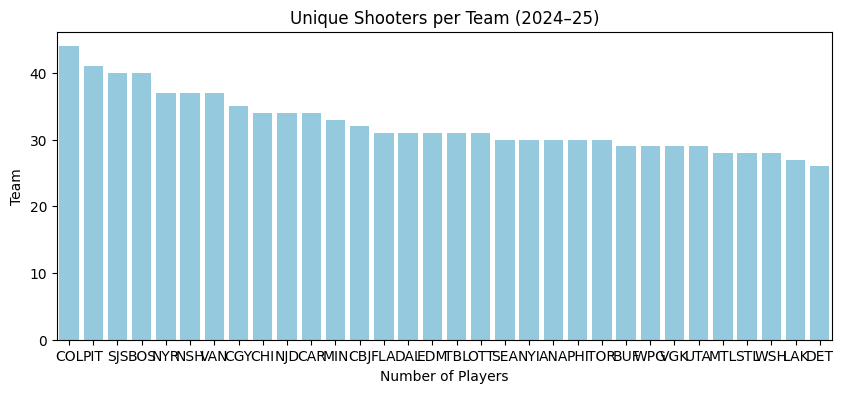

In [ ]:
# Group by team and count unique shooters
players_per_team = df.groupby('teamCode')['shooterName'].nunique().sort_values(ascending=False)

plt.figure(figsize=(10,4))
sns.barplot(y=players_per_team.values, x=players_per_team.index, color='skyblue')
plt.title('Unique Shooters per Team (2024–25)')
plt.xlabel('Number of Players')
plt.ylabel('Team')
plt.show()

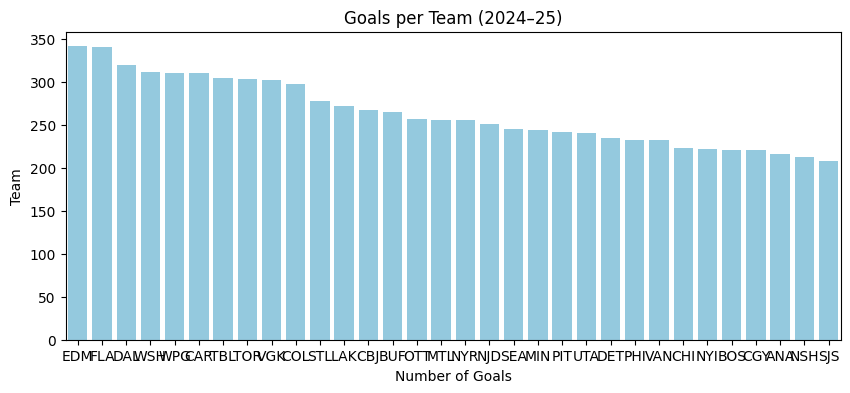

In [ ]:
# Group by team and count goals
goals_per_team = df.groupby('teamCode')['goal'].sum().sort_values(ascending=False)

plt.figure(figsize=(10,4))
sns.barplot(y=goals_per_team.values, x=goals_per_team.index, color='skyblue')
plt.title('Goals per Team (2024–25)')
plt.xlabel('Number of Goals')
plt.ylabel('Team')
plt.show()

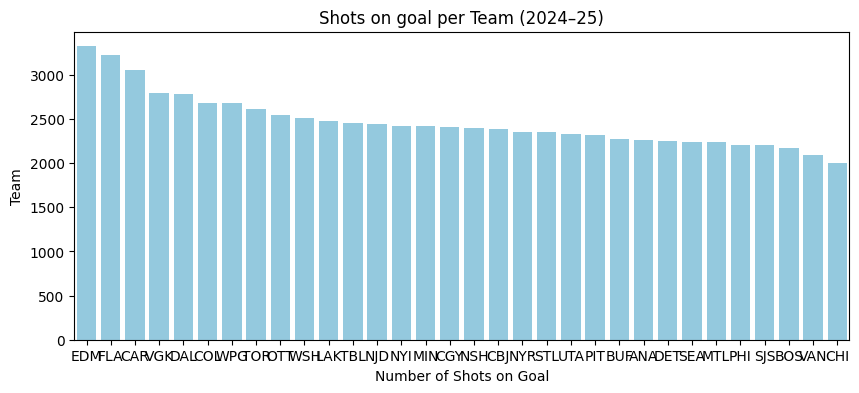

In [ ]:
# Group by team and count shots on goal
sog_per_team = df.groupby('teamCode')['SOG'].sum().sort_values(ascending=False)

plt.figure(figsize=(10,4))
sns.barplot(y=sog_per_team.values, x=sog_per_team.index, color='skyblue')
plt.title('Shots on goal per Team (2024–25)')
plt.xlabel('Number of Shots on Goal')
plt.ylabel('Team')
plt.show()

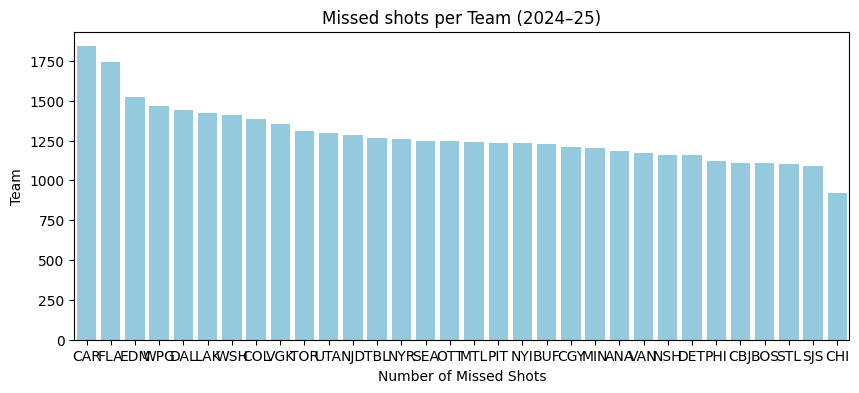

In [ ]:
# Group by team and count goals
miss_per_team = df.groupby('teamCode')['Missed'].sum().sort_values(ascending=False)

plt.figure(figsize=(10,4))
sns.barplot(y=miss_per_team.values, x=miss_per_team.index, color='skyblue')
plt.title('Missed shots per Team (2024–25)')
plt.xlabel('Number of Missed Shots')
plt.ylabel('Team')
plt.show()

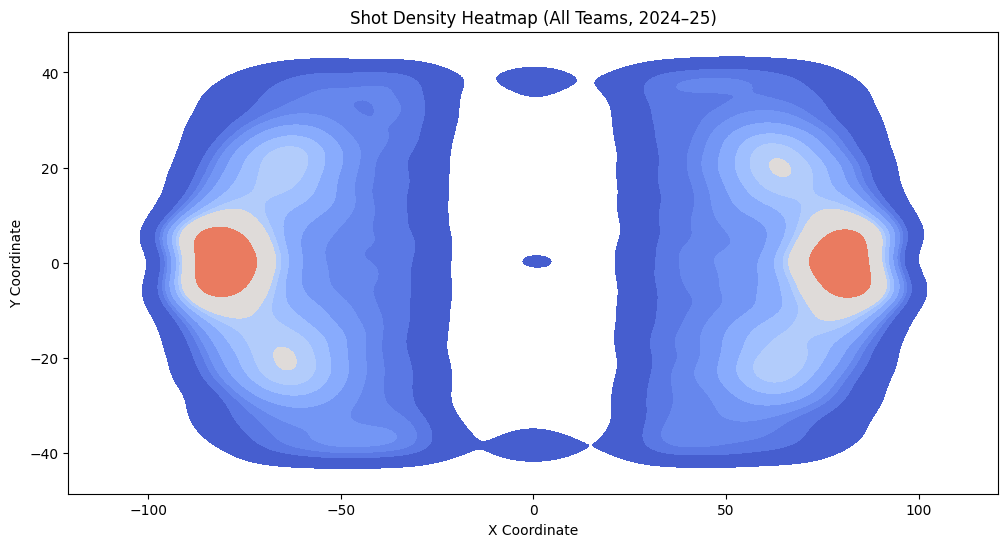

In [ ]:
# Filter for shots on goal (or include goals, depending on what you want)
shots_on_goal = df[df['event'].isin(['SHOT', 'GOAL'])]

plt.figure(figsize=(12,6))

# Draw a kernel density heatmap
sns.kdeplot(
    x=shots_on_goal['xCord'],
    y=shots_on_goal['yCord'],
    fill=True,
    cmap='coolwarm',
    bw_adjust=0.7,   # adjust smoothing (smaller = sharper)
    thresh=0.05      # ignore very low densities
)

plt.title('Shot Density Heatmap (All Teams, 2024–25)')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')

plt.show()


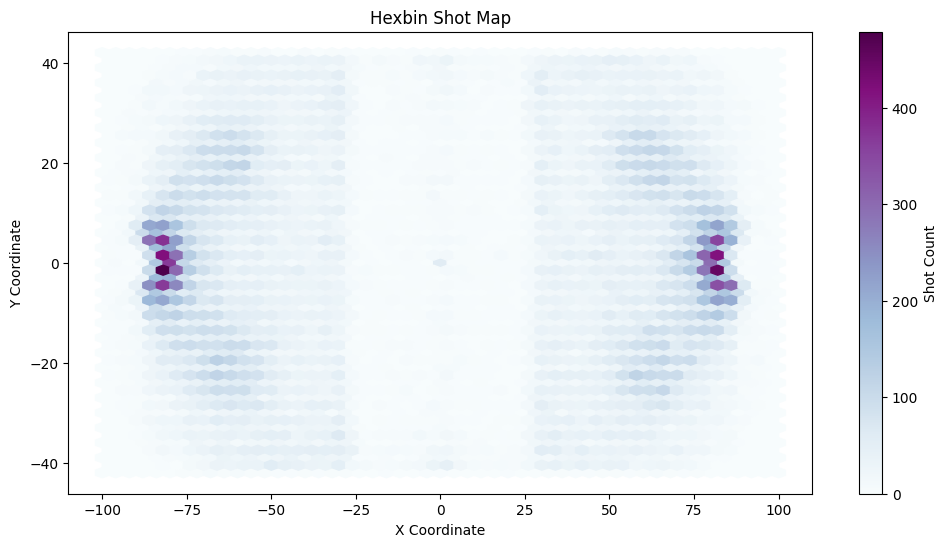

In [ ]:
plt.figure(figsize=(12,6))
plt.hexbin(
    shots_on_goal['xCord'],
    shots_on_goal['yCord'],
    gridsize=50,      # fewer = bigger hexagons
    cmap='BuPu'
)

plt.colorbar(label='Shot Count')
plt.title('Hexbin Shot Map')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()


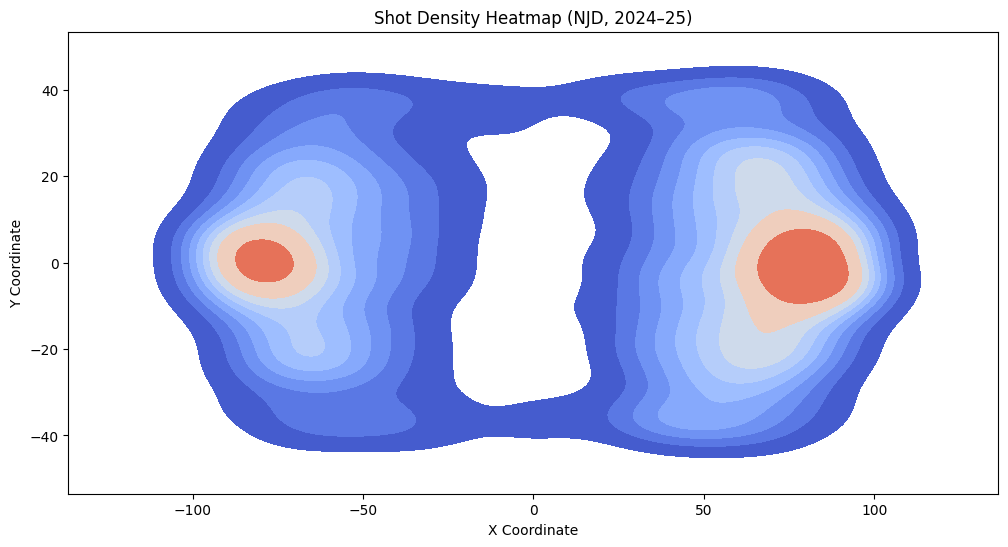

In [ ]:
team = 'NJD'
team_shots = shots_on_goal[shots_on_goal['teamCode'] == team]

plt.figure(figsize=(12,6))

# Draw a kernel density heatmap
sns.kdeplot(
    x=team_shots['xCord'],
    y=team_shots['yCord'],
    fill=True,
    cmap='coolwarm',
    bw_adjust=0.7,   # adjust smoothing (smaller = sharper)
    thresh=0.05      # ignore very low densities
)

plt.title('Shot Density Heatmap (NJD, 2024–25)')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')

plt.show()

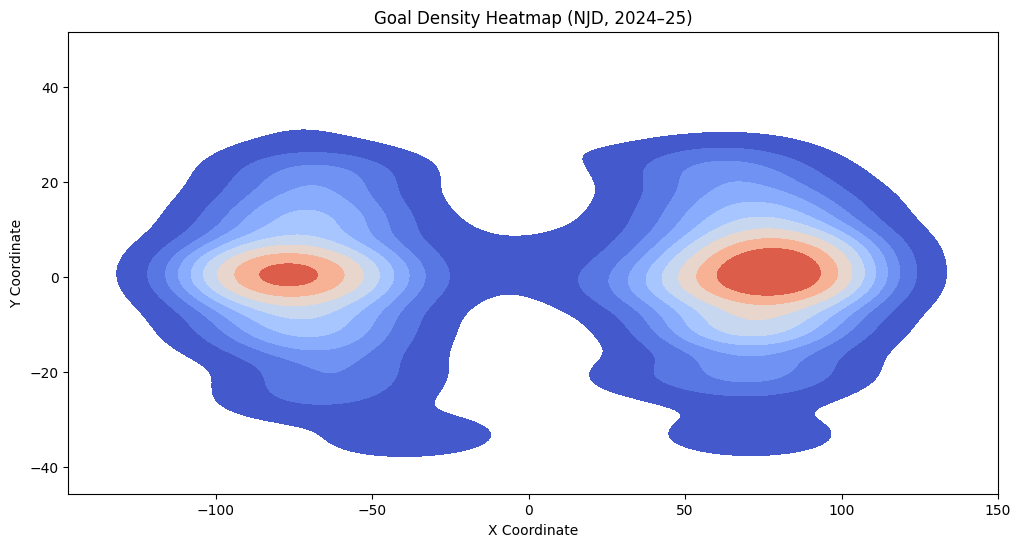

In [ ]:
# Devils goal vs no goal shot maps (all on net)
all_goal = df[df['event'].isin(['GOAL'])]
goal = all_goal[all_goal['teamCode'] == team]

plt.figure(figsize=(12,6))

# Draw a kernel density heatmap
sns.kdeplot(
    x=goal['xCord'],
    y=goal['yCord'],
    fill=True,
    cmap='coolwarm',
    bw_adjust=0.7,   # adjust smoothing (smaller = sharper)
    thresh=0.05      # ignore very low densities
)

plt.title('Goal Density Heatmap (NJD, 2024–25)')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')

plt.show()

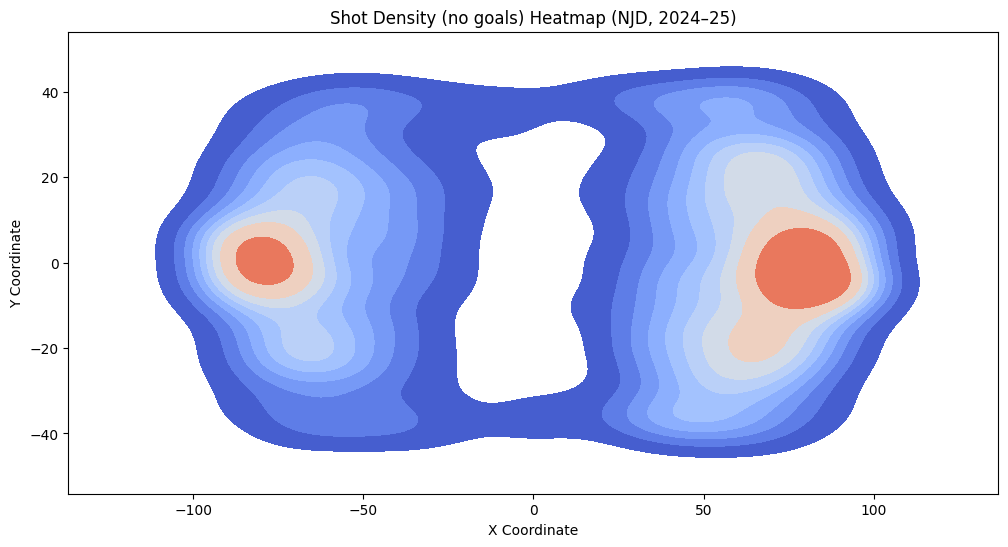

In [ ]:
all_shot = df[df['event'].isin(['SHOT'])]
shot = all_shot[all_shot['teamCode'] == team]

plt.figure(figsize=(12,6))

# Draw a kernel density heatmap
sns.kdeplot(
    x=shot['xCord'],
    y=shot['yCord'],
    fill=True,
    cmap='coolwarm',
    bw_adjust=0.7,   # adjust smoothing (smaller = sharper)
    thresh=0.05      # ignore very low densities
)

plt.title('Shot Density (no goals) Heatmap (NJD, 2024–25)')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')

plt.show()

Need to redo above two graphs, did not filter for NJD

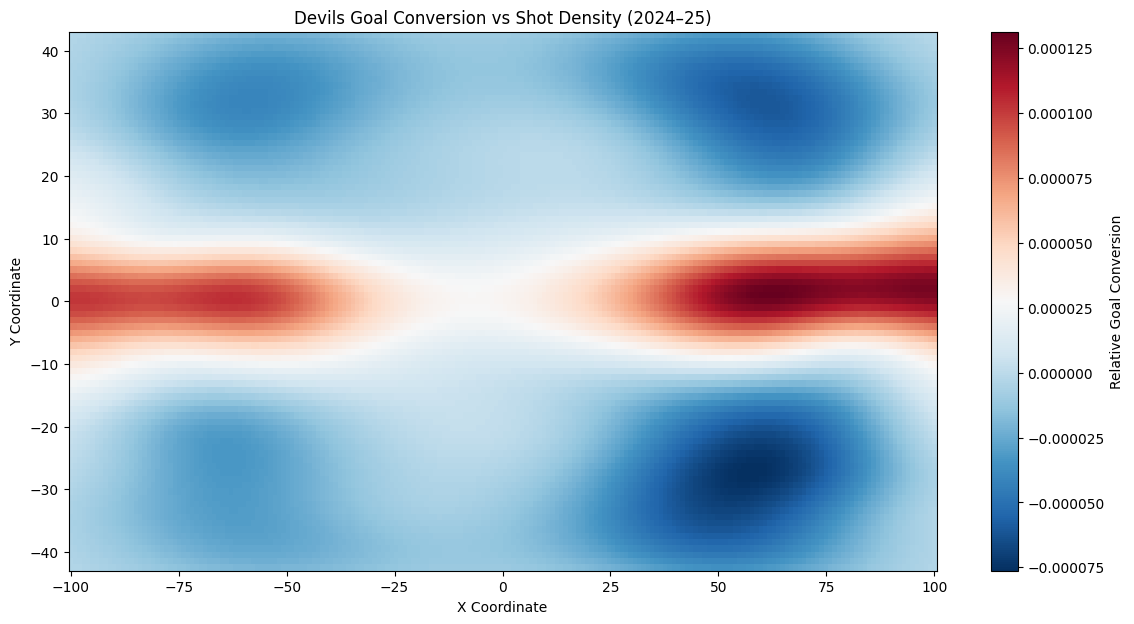

In [ ]:
# Difference goals vs shots NJD

# Build grid over rink space
x = np.linspace(-100, 100, 200)
y = np.linspace(-42.5, 42.5, 85)
X, Y = np.meshgrid(x, y)
coords = np.vstack([X.ravel(), Y.ravel()])

# KDE for shots
kde_shots = gaussian_kde(np.vstack([shot['xCord'], shot['yCord']]))
Z_shots = kde_shots(coords).reshape(X.shape)

# KDE for goals
kde_goals = gaussian_kde(np.vstack([goal['xCord'], goal['yCord']]))
Z_goals = kde_goals(coords).reshape(X.shape)

# Normalize so densities integrate to 1
Z_shots /= Z_shots.sum()
Z_goals /= Z_goals.sum()

# Difference (goals - shots)
Z_diff = Z_goals - Z_shots

plt.figure(figsize=(14,7))

# Diverging colormap: red = more goals than shots, blue = fewer goals
heat = plt.pcolormesh(X, Y, Z_diff, cmap='RdBu_r', shading='auto')

plt.colorbar(heat, label='Relative Goal Conversion')
plt.title('Devils Goal Conversion vs Shot Density (2024–25)')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')

plt.show()

In [ ]:
# create some features

#game situtation: 5v5, 5v4, 4v4, etc
df['situation'] = df['homeSkatersOnIce'].astype(str) + "v" + df['awaySkatersOnIce'].astype(str)

# Create score differential from shooter's perspective
df['scoreDifferential'] = np.where(
    df['isHomeTeam'] == 1,   # condition
    df['homeTeamGoals'] - df['awayTeamGoals'],  # if shooter is home team
    df['awayTeamGoals'] - df['homeTeamGoals']   # if shooter is away team
)

# Create categorical score state from shooter's perspective
df['scoreState'] = pd.cut(
    df['scoreDifferential'],
    bins=[-np.inf, -0.5, 0.5, np.inf],  # ranges: trailing, tied, leading
    labels=['Trailing', 'Tied', 'Leading']
)